## <center>SCNN auf Basis von VGG-16 </center>

Import der notwendigen Funktionen aus keras, um die CNN Struktur aufbauen zu können
Import der matplotlib, um Graphen darzustellen
Import von numpy zur Tätigung von Berechnungen etc.



In [1]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape, Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import math
import copy
import os

Using TensorFlow backend.


Das VGG-16 Architektur wird aufgestellt und die einzelnen Schichten werden hinzugefügt (vgl. Serengil, S. I., Deep Face Recognition with Keras, https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/, (17.3.2019)).

In [2]:
VGG_16 = Sequential()
VGG_16.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
VGG_16.add(Convolution2D(64, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(64, (3, 3), activation='relu'))
VGG_16.add(MaxPooling2D((2,2), strides=(2,2)))
 
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(128, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(128, (3, 3), activation='relu'))
VGG_16.add(MaxPooling2D((2,2), strides=(2,2)))
 
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(256, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(256, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(256, (3, 3), activation='relu'))
VGG_16.add(MaxPooling2D((2,2), strides=(2,2)))
 
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_16.add(MaxPooling2D((2,2), strides=(2,2)))
 
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_16.add(ZeroPadding2D((1,1)))
VGG_16.add(Convolution2D(512, (3, 3), activation='relu'))
VGG_16.add(MaxPooling2D((2,2), strides=(2,2)))
 
VGG_16.add(Convolution2D(4096, (7, 7), activation='relu'))
VGG_16.add(Dropout(0.5))
VGG_16.add(Convolution2D(4096, (1, 1), activation='relu'))
VGG_16.add(Dropout(0.5))
VGG_16.add(Convolution2D(2622, (1, 1)))
VGG_16.add(Flatten())
VGG_16.add(Activation('softmax'))

Vortrainierte Gewichte werden in das Netz geladen (https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view).

In [3]:
VGG_16.load_weights('C:/weights/vgg_face_weights.h5')

Die VGG-Gesichtsdeskriptoren werden extrahiert, um die Bilder aus der Datenbank (Quelldarstellung) und der den Zugriff auf die Institution anfragenden Person (Zieldarstellung) darzustellen. Hierbei wurde die Klassifikationsschicht nicht berücksichtigt (Softmax).

In [4]:
vgg_face_descriptor = Model(inputs=VGG_16.layers[0].input
, outputs=VGG_16.layers[-2].output)

Die verschiedenen Parameter für die Vorverarbeitung des Zielbildes werden definiert.

In [5]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

Die Kosinus Distanz und die Euklidische Distanz zwischen zwei Bildern werden definiert.

In [6]:
def CosineSimilarity(Bild_1, Bild_2):
    a = np.matmul(np.transpose(Bild_1), Bild_2)
    b = np.sum(np.multiply(Bild_1, Bild_1))
    c = np.sum(np.multiply(Bild_2, Bild_2))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def EuclideanDistance(Bild_1, Bild_2):
    euclidean_distance = Bild_1 - Bild_2
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In der Endphase werden das Bildverzeichnis der Datenbank der Mitarbeiter (mit jeweils nur einem Bild) und das zugeschnittene Bild der Person am Zugangspunkt in das System eingegeben.
Die endgültige Ausgabe gibt die Nachricht aus, ob die Person Zugriff hat (wenn festgestellt wird, dass sie dieselbe Person ist wie in der Datenbank) oder nicht. Es ist zu beachten, dass das VGG-Gesicht im Wesentlichen mit quadratisch zentrierten Bildern mit Frontalgesichtern trainiert wurd. Um das beste Ergebnisse zu erzielen, ist es erforderlich, dass das Foto auch quadratisch, zentriert und frontal aufzunehmen.

[119.78868866]
[0.522941529750824]
position:0
[148.93283081 119.78868866]
[0.522941529750824]
position:0
[118.34849548 148.93283081 119.78868866]
[0.5220735371112823]
position:4
[109.13111115 118.34849548 148.93283081 119.78868866]
[0.42076539993286133]
position:6
[139.53996277 109.13111115 118.34849548 148.93283081 119.78868866]
[0.42076539993286133]
position:6
[107.36390686 139.53996277 109.13111115 118.34849548 148.93283081
 119.78868866]
[0.42076539993286133]
position:6
[150.47354126 107.36390686 139.53996277 109.13111115 118.34849548
 148.93283081 119.78868866]
[0.42076539993286133]
position:6
[134.41036987 150.47354126 107.36390686 139.53996277 109.13111115
 118.34849548 148.93283081 119.78868866]
[0.42076539993286133]
position:6
[140.91734314 134.41036987 150.47354126 107.36390686 139.53996277
 109.13111115 118.34849548 148.93283081 119.78868866]
[0.42076539993286133]
position:6
[146.40579224 140.91734314 134.41036987 150.47354126 107.36390686
 139.53996277 109.13111115 118.3484

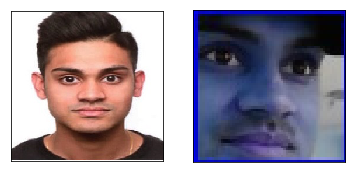

-----------------------------------------
Prozess beendet


In [8]:
employee_pictures = "C:/Users/manum/Desktop/Confusion/"
img2= "cropped.jpg"
employees = dict()
epsilon = 0.35 # Schwellenwert der Kosinus Ähnlichkeit setzen
alpha = 120 # Schwellenwert der Euklidischen Distanz setzen
# Maximale Anzahl der Bilder definieren
result_arraya = np.empty(([0, 1000]))
result_arrayb = np.empty(([0, 1000]))
result_array1 = np.empty((0, 1000))
resultedarr1 = np.empty((0, 1000))
i = 0
for file in os.listdir(employee_pictures):
    employee, extension = file.split(".")
    # Den Namen aus dem Angestellten Ordner extrahieren 
    testimage = '%s' % (employee)
    employees[employee] = vgg_face_descriptor.predict(preprocess_image(employee_pictures+'%s.jpg' % (employee)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image((img2)))[0,:]
    cosine_similarity = CosineSimilarity(employees[employee] , img2_representation)
   # print ( cosine_similarity)
    euclidean_distance = EuclideanDistance(employees[employee] , img2_representation)
   # print ( euclidean_distance)
    result = cosine_similarity
    resulted = euclidean_distance
    resulta = np.array([result, testimage], dtype=object)
    resultedarr = np.array([resulted], dtype=float)
    resultedarr1 = np.append([resultedarr], resultedarr1)
    # Array beider Werte (Kosinus Ähnlichkeit und Label)
    print (resultedarr1)
    resultb = np.array([result], dtype=float)
    result_arraya = np.append(result_arraya, [resulta])
    result_arrayb = np.append(result_arrayb, [resultb])
    result1 = euclidean_distance
    result_array1 = np.append(result_array1, [result1])
    mina = (np.where(result_arraya==result_arrayb.min()))
    # Der kleinste Kosinus Ähnlichkeitswert  
    print (result_arraya[mina])
    print("position:%d" %mina[0])
    #print(mina[0])
    level = ((list(mina[0])))
print (np.sort(result_array1))
print (level[0]+1)
print ("Geringste Euklidische Distanz bei : %f" %min(resultedarr1))
#print ("Geringste Euklidische Distanz bei : %f" %min(resultedarr1[level]))
print("Geringste Kosinus Distanz bei: %f" %min(result_arrayb))
#print(result_arraya[mina[0]])
print("Der Name der Datei ist: %s" %result_arraya[(level[0]+1)])
if ((min(result_arrayb) < epsilon) and (min(resultedarr1) < 1000)):
        print("Zugriff erlaubt... Person identifiziert")
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(image.load_img(employee_pictures+result_arraya[(level[0]+1)]+'.jpg' ))
        plt.xticks([]); plt.yticks([])
        f.add_subplot(1,2, 2)
        plt.imshow(image.load_img((img2)))
        plt.xticks([]); plt.yticks([])
        plt.show(block=True)
        print("-----------------------------------------")
        #break
        verified = 1
else:
        verified = 0

if (verified == 1):
    print("Prozess beendet")
else:
    print("Unbekannte Person")


## Referenzen
* [Keras Framework](https://keras.io/)
* [Deep Face Recognition Paper der Oxford Universität](https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf)